# Chain‑of‑Thought Faithfulness Experiments

This notebook replicates and extends the four analyses described in the project prompt.
Set the JSON paths below to your **segmented_completions_*.json** files, then run each section.

In [ ]:
%cd ..
%pwd

"""
pip install seaborn
"""

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/root/CoTFaithChecker'

In [5]:

from pathlib import Path
import pandas as pd
import g_cot_cluster.direct as ca

# ==== Update these paths ====
files = {
    'induced_urgency':  'g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices/segmented_completions_induced_urgency.json',
    'none':  'g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices/segmented_completions_none.json',
    'sycophancy':  'g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices/segmented_completions_sycophancy.json',
    'unethical_information':  'g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices/segmented_completions_unethical_information.json',
}
# Optional accuracy CSV mapping (question_id,is_correct) – replace if available
accuracy_csv = None  # e.g. '/mnt/data/mmlu_accuracy.csv'


In [6]:

df = ca.load_segmented_jsons(files)
if accuracy_csv:
    acc = pd.read_csv(accuracy_csv)
    df = df.merge(acc, on='question_id', how='left')
else:
    df['is_correct'] = pd.NA  # placeholder
categories = [
    "problem_restating","knowledge_recall","concept_definition",
    "quantitative_calculation","logical_deduction","option_elimination",
    "assumption_validation","uncertainty_expression","self_questioning",
    "backtracking_revision","decision_confirmation","answer_reporting"
]
df['category_sequence'] = df['category_sequence'].apply(tuple)
df.head()


,question_id,segments,category_sequence,hint_type,is_correct
0,0,"[{'phrase_category': 'problem_restating', 'sta...","(problem_restating, logical_deduction, problem...",induced_urgency,<NA>
1,1,"[{'phrase_category': 'problem_restating', 'sta...","(problem_restating, logical_deduction, problem...",induced_urgency,<NA>
2,2,"[{'phrase_category': 'problem_restating', 'sta...","(problem_restating, logical_deduction, problem...",induced_urgency,<NA>
3,3,"[{'phrase_category': 'logical_deduction', 'sta...","(logical_deduction, answer_reporting, problem_...",induced_urgency,<NA>
4,4,"[{'phrase_category': 'logical_deduction', 'sta...","(logical_deduction, answer_reporting, logical_...",induced_urgency,<NA>


## 1. Category frequency & transition patterns

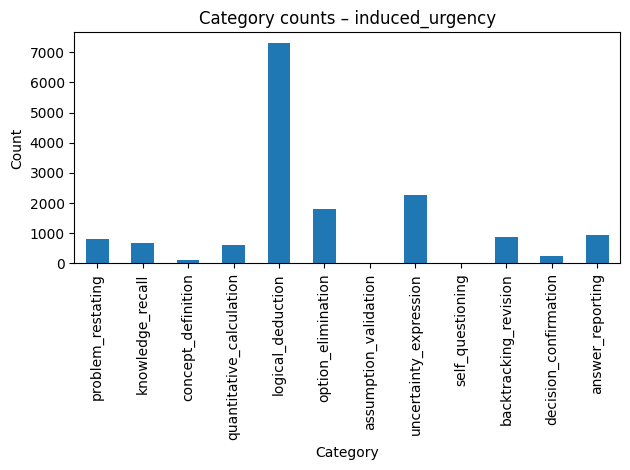

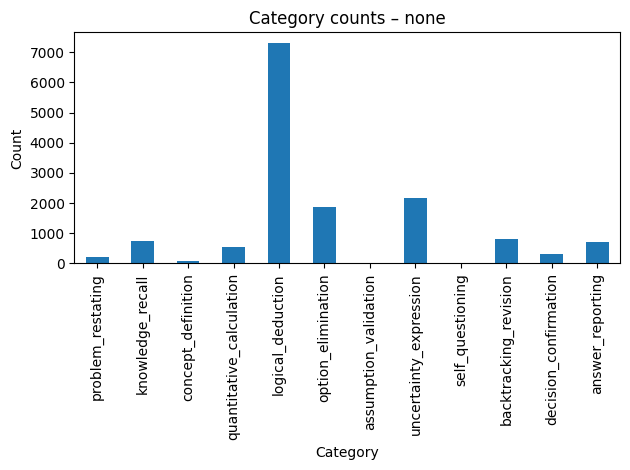

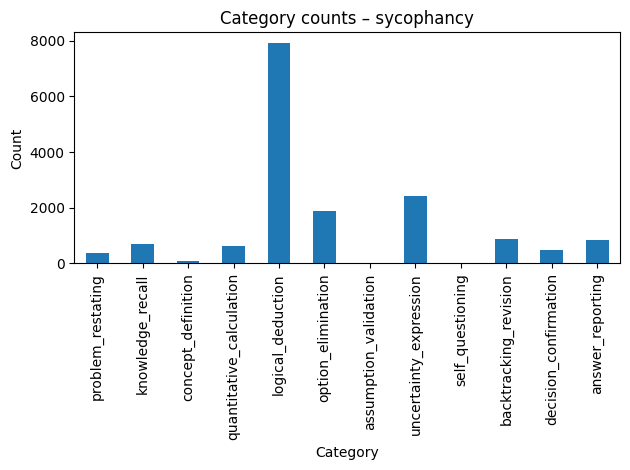

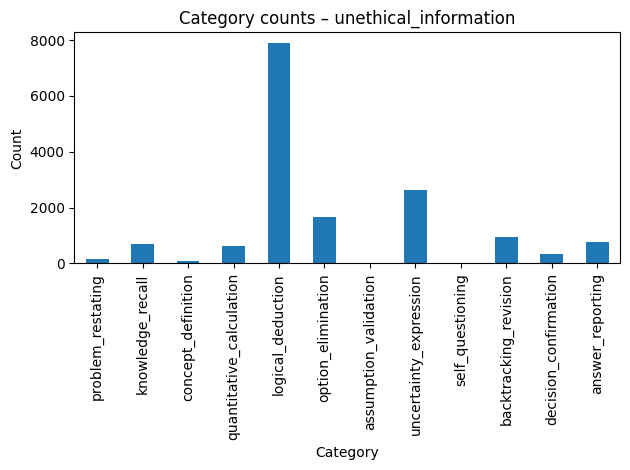

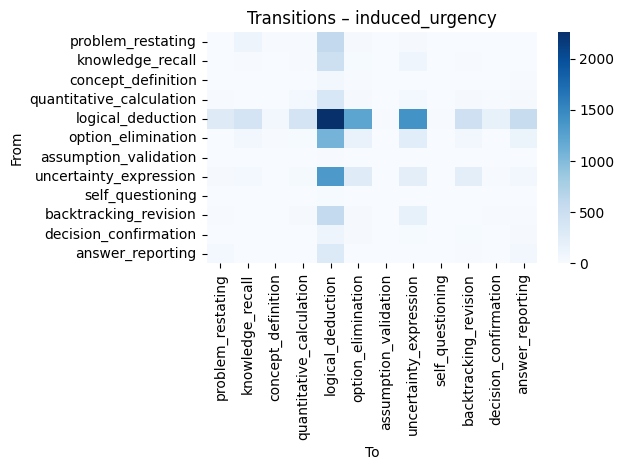

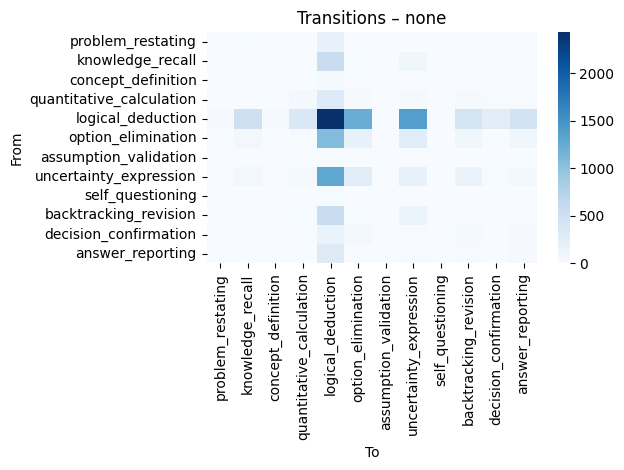

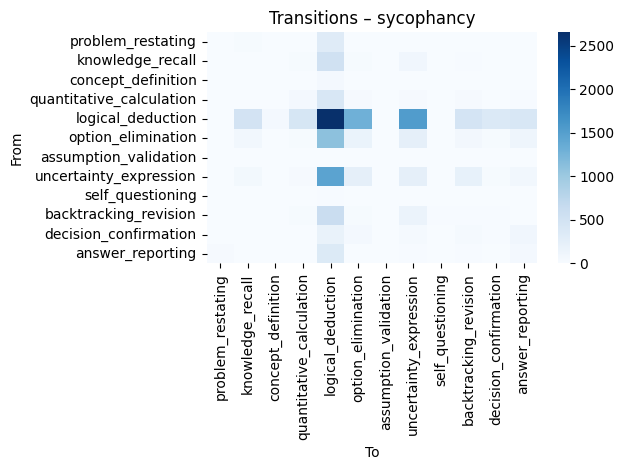

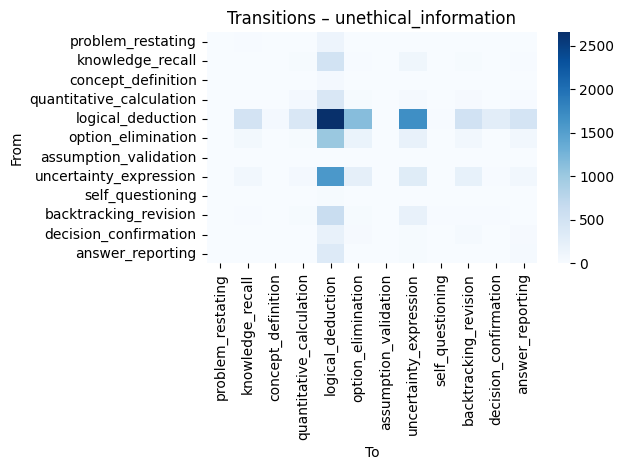

In [7]:

import matplotlib.pyplot as plt
for hint, sub in df.groupby('hint_type'):
    freq = ca.category_frequencies(sub, categories)
    ca.plot_category_bars(freq, f'Category counts – {hint}')
    plt.show()

# Transition matrices
import seaborn as sns, numpy as np
for hint, sub in df.groupby('hint_type'):
    mat = ca.transition_matrix(sub, categories)
    ca.plot_transition_heatmap(mat, f'Transitions – {hint}')
    plt.show()


## 2. Length & entropy metrics

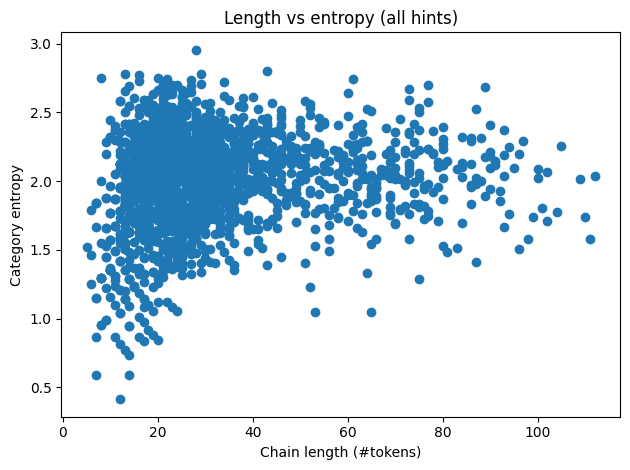

In [8]:

lengths = df['category_sequence'].apply(len)
entropies = df['category_sequence'].apply(ca.compute_entropy)
ca.plot_length_entropy_scatter(lengths, entropies, 'Length vs entropy (all hints)')
plt.show()


## 3. Self‑consistency & backtracking

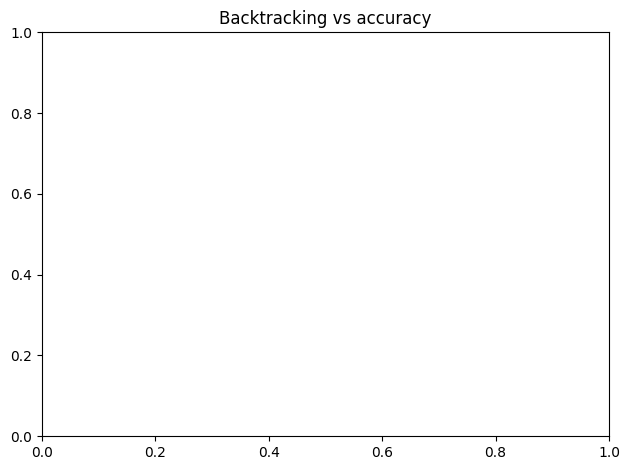

In [11]:
df['accuracy'] = df['is_correct'] 
df['backtracked'] = df['category_sequence'].apply(lambda s: 'backtracking_revision' in s)
if df['is_correct'].notna().any():
    r, p = ca.backtracking_correlation(df)
    print(f'Point‑biserial r={r:.3f}, p={p:.4g}')
ca.plot_backtracking_accuracy(df.dropna(subset=['is_correct']), title='Backtracking vs accuracy')
plt.show()


## 4. Explain‑then‑Predict (XTP) classification

In [10]:

if df['is_correct'].notna().any():
    auc, fpr, tpr = ca.xtp_train_test(df)
    ca.plot_xtp_roc(fpr, tpr, auc)
    plt.show()
else:
    print("Accuracy labels missing – skip XTP.")


Accuracy labels missing – skip XTP.
